In [1]:
import pandas as pd
import numpy as np

from scipy.optimize import minimize
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression

In [2]:
# links used

# https://github.com/tthustla/efficient_frontier/blob/master/Efficient%20_Frontier_implementation.ipynb
# https://www.kaggle.com/code/trangthvu/efficient-frontier-optimization

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
df = pd.read_csv('project_RM.csv')
df['<DATE>'] = pd.to_datetime(df['<DATE>'], format="%d/%m/%y")
df.columns = ['TICKER', 'DATE', 'CLOSE']

In [5]:
tickers = df['TICKER'].unique()

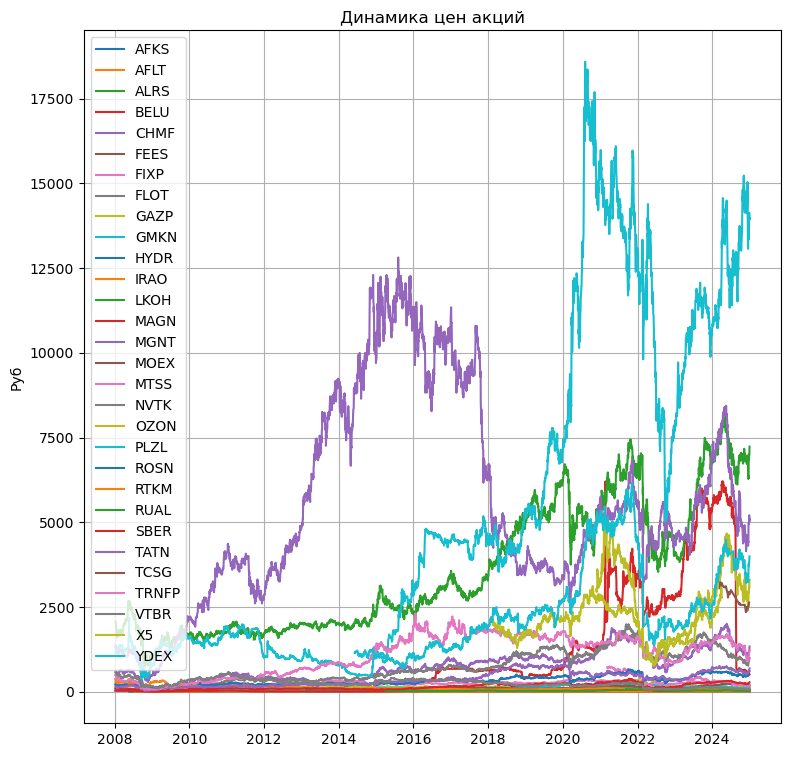

In [6]:
plt.figure(figsize = (9,9))
plt.title('Динамика цен акций')

for ticker in tickers:

    mask = df['TICKER'].eq(ticker)
    
    plt.plot(df[mask]['DATE'], df[mask]['CLOSE'], label = ticker)

plt.legend()
plt.grid()
plt.ylabel('Руб');

In [7]:
# Выбор исторического окна: 2019-12-31 по 2024-12-31
start_date = '2019-12-31'
end_date = '2024-12-31'
df_window = df[(df['DATE'] >= start_date) & (df['DATE'] <= end_date)]

In [8]:
pivot_data = df_window.pivot(index='DATE', columns='TICKER', values='CLOSE').sort_index(ascending=True)

In [9]:
len(pivot_data)

1250

In [10]:
pivot_data.isna().sum() / len(pivot_data) * 100

TICKER
AFKS      0.00
AFLT      0.00
ALRS      0.00
BELU      0.48
CHMF      0.00
FEES      1.12
FIXP     23.92
FLOT     15.44
GAZP      0.00
GMKN      0.32
HYDR      0.00
IRAO      0.00
LKOH      0.00
MAGN      0.00
MGNT      0.00
MOEX      0.00
MTSS      0.00
NVTK      0.00
OZON     18.16
PLZL      0.00
ROSN      0.00
RTKM      0.00
RUAL      0.32
SBER      0.00
TATN      0.00
TCSG     97.52
TRNFP     0.32
VTBR      0.32
X5       15.60
YDEX      2.40
dtype: float64

Text(0, 0.5, 'daily returns')

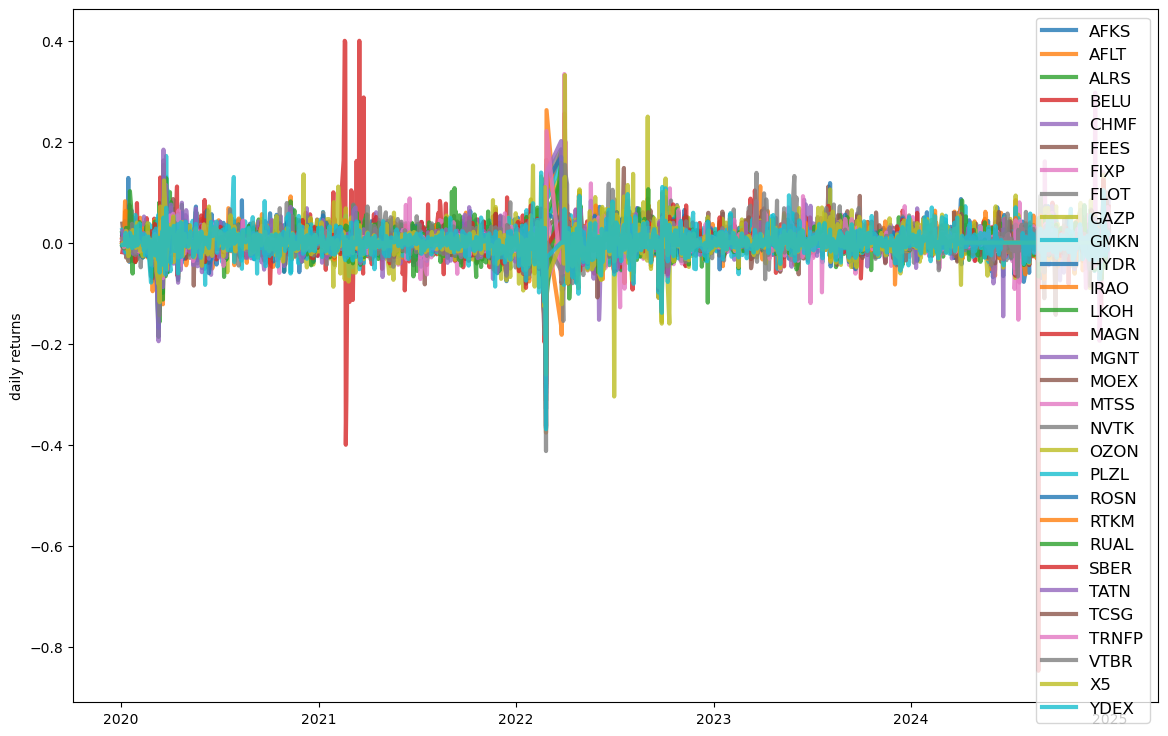

In [11]:
returns = pivot_data.pct_change()

plt.figure(figsize=(14, 9))
for c in returns.columns.values:
    plt.plot(returns.index, returns[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper right', fontsize=12)
plt.ylabel('daily returns')

__Граница эффективности портфелей__ - combination of stocks that has the lowest risk for a given expected return

In [12]:
returns = pivot_data.pct_change()
mean_returns = returns.mean()
cov_matrix = returns.cov()
num_portfolios = 25000
risk_free_rate = 0.1

In [13]:
# Выбрать схему взвешивания наблюдений для последующего расчёта границы эффективных портфелей для различных ограничений. 

num_intervals = len(returns.index.unique())
num_months = num_intervals

lambda_ = 0.97
weights = np.array([lambda_**(num_months - t - 1) for t in range(num_months)])
weights = weights / np.sum(weights)  # Нормировка весов

# Присвоение весов к данным
date_weights = dict(zip(returns.index.unique(), weights))

returns['w'] = returns.index.map(date_weights)

# for col in returns.columns[:-1]:
#     returns[col] = returns[col] * returns['w']

In [14]:
from frontier import (portfolio_annualised_performance,
                        neg_sharpe_ratio,
                        max_sharpe_ratio,
                        portfolio_volatility,
                        min_variance,
                        calculated_results,
                        efficient_return
                    )

/Applications/anaconda/anaconda3/lib/python3.9/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


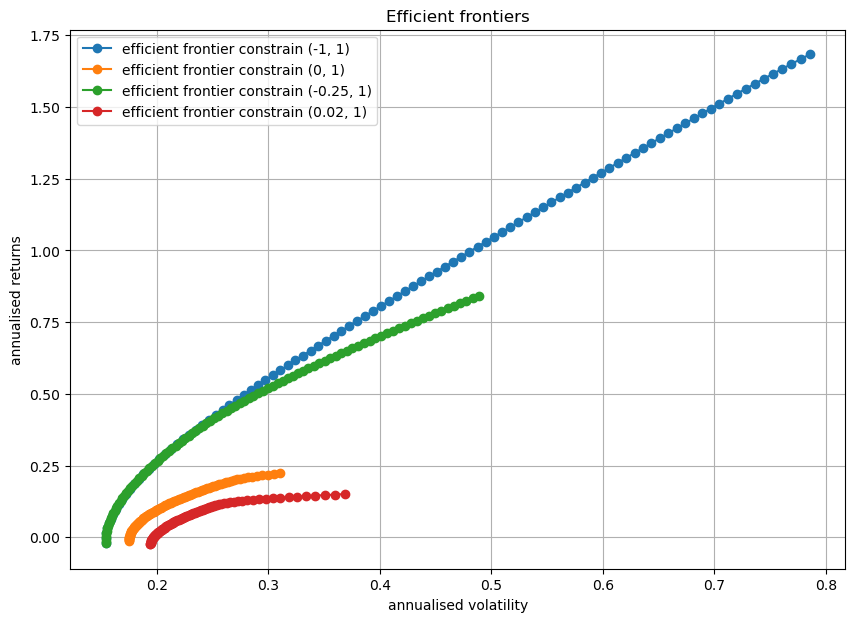

In [15]:
plt.figure(figsize=(10, 7))
plt.title(f'Efficient frontiers')

# короткие продажи разрешены без ограничений
constarin_set = (-1,1)
maxSR_std, maxSR_returns, maxSR_allocation, minVol_std, minVol_returns, minVol_allocation, efficient_list, target_returns = calculated_results(mean_returns,
                                                                                                                                               cov_matrix,
                                                                                                                                               risk_free_rate,
                                                                                                                                               pivot_data,
                                                                                                                                              constarin_set)
plt.plot(efficient_list,target_returns, label = f'efficient frontier constrain {constarin_set}', marker = 'o')

# короткие продажи запрещены
constarin_set = (0,1)
maxSR_std, maxSR_returns, maxSR_allocation, minVol_std, minVol_returns, minVol_allocation, efficient_list, target_returns = calculated_results(mean_returns,
                                                                                                                                               cov_matrix,
                                                                                                                                               risk_free_rate,
                                                                                                                                               pivot_data,
                                                                                                                                              constarin_set)
plt.plot(efficient_list,target_returns, label = f'efficient frontier constrain {constarin_set}', marker = 'o')

# доходы от короткой продажи каждой акции не должны превышать 25% от собственных средств (капитала) инвестора
constarin_set = (-0.25,1)
maxSR_std, maxSR_returns, maxSR_allocation, minVol_std, minVol_returns, minVol_allocation, efficient_list, target_returns = calculated_results(mean_returns,
                                                                                                                                               cov_matrix,
                                                                                                                                               risk_free_rate,
                                                                                                                                               pivot_data,
                                                                                                                                              constarin_set)
plt.plot(efficient_list,target_returns, label = f'efficient frontier constrain {constarin_set}', marker = 'o')


# 0.02% капитала должно быть вложено в каждую акцию
constarin_set = (0.02,1)
maxSR_std, maxSR_returns, maxSR_allocation, minVol_std, minVol_returns, minVol_allocation, efficient_list, target_returns = calculated_results(mean_returns,
                                                                                                                                               cov_matrix,
                                                                                                                                               risk_free_rate,
                                                                                                                                               pivot_data,
                                                                                                                                              constarin_set)
plt.plot(efficient_list,target_returns, label = f'efficient frontier constrain {constarin_set}', marker = 'o')


plt.xlabel('annualised volatility')
plt.ylabel('annualised returns')
plt.legend()
plt.grid()

# Betas. Tasks 11-20

11. Выбираем в качестве индекса индекс Московской биржи - IMOEX. Обоснование - Индекс содержит 47 акций крупных публичных российских компаний, хорошо отражает состояние большинства значимых экономических отраслей российской экономики.

In [16]:
# market model for calculating betas, alphas

def train_lr(ds, moex, add_const=True, returns_window=1):
    
    betas, alphas = {}, {}
    
    ds = ds.copy()
    
    ds['moex'] = moex
    
    ds = ds.iloc[[i*returns_window for i in range(ds.shape[0]//returns_window)]]
    
    
    if add_const: ds['const'] = [1] * len(ds)
    
    for ticker in ds.columns:
        
        y = ds[ticker]
        
        model = LinearRegression(fit_intercept=False)
        
        if ds[ticker].isna().sum() > 0 or ticker in ['const', 'w', 'moex']:
            continue
        
        model.fit(ds[['const', 'moex']], y)
        
        coefs = model.coef_
        
        betas[ticker], alphas[ticker] = coefs[1], coefs[0]
    
    return alphas, betas

In [17]:
def find_historic_betas(pivot_data, returns_window = 150, silent=True, adjusted_beta=False):
    
    # downloading moex data
    moex_index = pd.read_csv('MOEX Russia Index Historical Data.csv') # источник - https://www.investing.com/indices/mcx-historical-data

    moex_index = moex_index.sort_index(ascending=False).reset_index(drop=True)
    moex_index['Price'] = moex_index['Price'].apply(lambda x: float(x.replace(',', '')))

    moex_index = moex_index['Price']
    
    # set historic window
#     returns_1 = pivot_data[(pivot_data['DATE'] >= historic_window_start) & (pivot_data['DATE'] <= historic_window_end)]
    
    # calculate returns
    returns_1 = pivot_data.pct_change(periods=returns_window)[1:]
    moex_index = moex_index.pct_change(periods=returns_window)
    
    returns_1 = returns_1[returns_window:]
    moex_index = moex_index[returns_window:]
    
    if moex_index.shape[0] > returns_1.shape[0]:
        moex_index = moex_index[-returns_1.shape[0]:]
        
    moex_index.index = returns_1.index
    
    # calculating historic betas
    alphas, betas = train_lr(returns_1, moex_index.values, returns_window=returns_window)
    
    #adjusted coefficients
    alpha_0 = 0.333
    alpha_1 = 0.667
    
    if adjusted_beta:
        for k in betas.keys():
            betas[k] = alpha_0 + alpha_1 * betas[k]
    
    # получаем среднюю доходность, ковариации с помощью бета
    market_mean = moex_index.mean()
    market_var = moex_index.var()

    expected_returns = {}
    variances = pd.DataFrame()

    for ticker in betas.keys():
        expected_returns[ticker] = alphas[ticker] + betas[ticker] * market_mean

        variances[ticker] = [betas[ticker] * betas[ticker_i] * market_var for ticker_i in betas.keys()]

    variances.index = betas.keys()
    
    expected_returns_1 = pd.Series(data = expected_returns.values(), index=expected_returns.keys())
    
    remaining_assets = expected_returns.keys()
    pivot_data_1 = returns_1[returns_1.index.isin(remaining_assets)][remaining_assets]
    
    # результаты регрессии 
    if not silent:
        plt.plot(moex_index, label='moex')

        stck = 'GAZP'
        plt.plot(returns_1[stck], label='stock')

        plt.plot(alphas[stck] + betas[stck] * moex_index, label='prediction')

        plt.legend()
        
        plt.show()
    
    
    return alphas, betas, expected_returns_1, variances, pivot_data_1
    

12. Выберем историческое окно - 1 неделя (5 рабочих дней). Такое окно позволит одновременно получить большое количество данных для оценки параметров и уменьшить неопределенность в связи с большими изменениями доходности за один день

In [18]:
# историческое окно 1, окно 1
returns_window = 5

start_date = '2019-12-31'
end_date = '2024-12-31'

pivot_data_1 = pivot_data[(pivot_data.index >= start_date) & (pivot_data.index <= end_date)]


alphas, betas, expected_returns_1, variances, pivot_data_1 = find_historic_betas(pivot_data_1, returns_window=returns_window, adjusted_beta=False)

13 посчитанные бета

In [19]:
betas

{'AFKS': 1.1625716585070316,
 'AFLT': 1.480963173770767,
 'ALRS': 0.8927289271715488,
 'BELU': 0.7332155478106617,
 'CHMF': 0.8511420702453849,
 'FEES': 0.9789189625729513,
 'GAZP': 1.0705604053481481,
 'GMKN': 0.7650797757143443,
 'HYDR': 0.702843600817681,
 'IRAO': 1.1152891170281782,
 'LKOH': 1.0690111670507012,
 'MAGN': 0.9762231688447318,
 'MGNT': 0.8822043794108355,
 'MOEX': 0.8635637361206899,
 'MTSS': 0.8408897409832471,
 'NVTK': 0.9847162262887522,
 'PLZL': 0.5921593936138085,
 'ROSN': 1.1997873396121412,
 'RTKM': 0.5466469343002599,
 'RUAL': 0.9548625432860598,
 'SBER': 1.2588829110538013,
 'TATN': 1.057017243286179,
 'TRNFP': 0.691425364306725,
 'VTBR': 1.3699826701967797,
 'X5': 0.9073272449502027,
 'YDEX': 1.0955873109541352}

14 - график границы эффективных портфелей

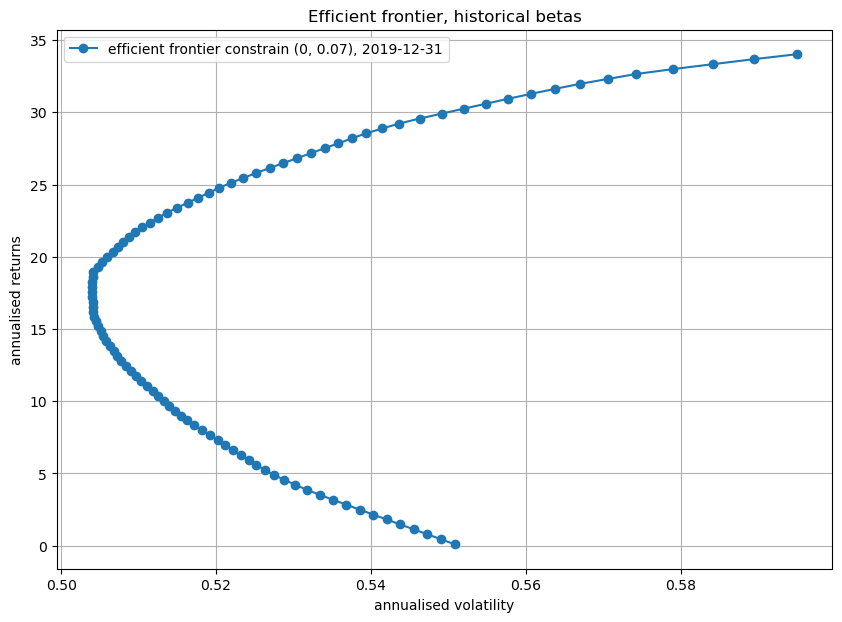

In [20]:
plt.figure(figsize=(10, 7))
plt.title(f'Efficient frontier, historical betas')

annual_multiplier = 252/returns_window

constarin_set = (0, 0.07)
maxSR_std, maxSR_returns, maxSR_allocation, minVol_std, minVol_returns, minVol_allocation, efficient_list, target_returns = calculated_results(expected_returns_1 * annual_multiplier,
                                                                                                                                               variances,
                                                                                                                                               risk_free_rate,
                                                                                                                                               pivot_data_1 * annual_multiplier,
                                                                                                                                              constarin_set,
                                                                                                                                              crazy=True)
plt.plot(efficient_list,target_returns, label = f'efficient frontier constrain {constarin_set}, {start_date}', marker = 'o')

plt.xlabel('annualised volatility')
plt.ylabel('annualised returns')
plt.legend()
plt.grid()

In [21]:
# Скорректированные бета

задания 16, 17

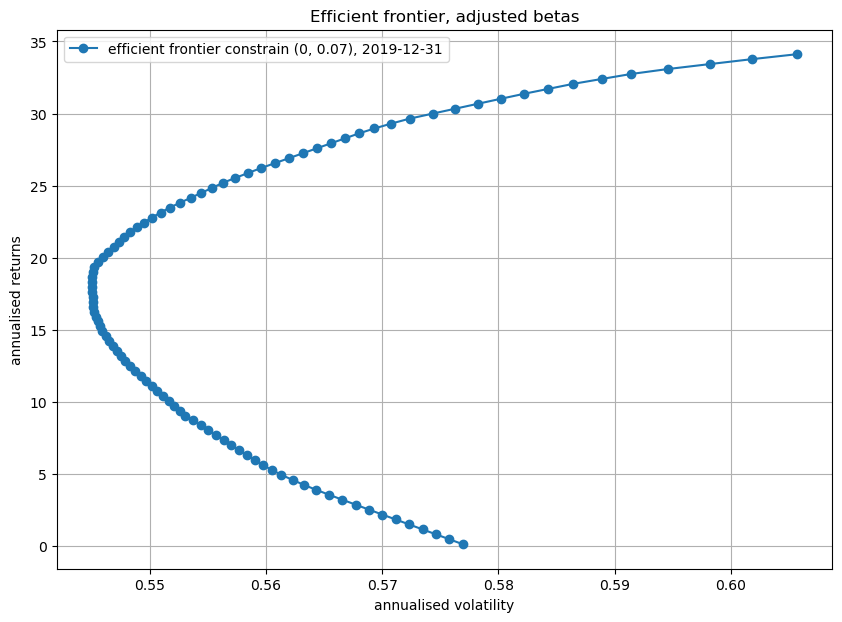

In [22]:
plt.figure(figsize=(10, 7))
plt.title(f'Efficient frontier, adjusted betas')

# историческое окно 1, окно 1
returns_window = 5

start_date = '2019-12-31'
end_date = '2024-12-31'

pivot_data_1 = pivot_data[(pivot_data.index >= start_date) & (pivot_data.index <= end_date)]


alphas, betas, expected_returns_1, variances, pivot_data_1 = find_historic_betas(pivot_data_1, returns_window=returns_window, adjusted_beta=True)

annual_multiplier = 252/returns_window

constarin_set = (0, 0.07)
maxSR_std, maxSR_returns, maxSR_allocation, minVol_std, minVol_returns, minVol_allocation, efficient_list, target_returns = calculated_results(expected_returns_1 * annual_multiplier,
                                                                                                                                               variances,
                                                                                                                                               risk_free_rate,
                                                                                                                                               pivot_data_1 * annual_multiplier,
                                                                                                                                              constarin_set,
                                                                                                                                              crazy=True)
plt.plot(efficient_list,target_returns, label = f'efficient frontier constrain {constarin_set}, {start_date}', marker = 'o')

plt.xlabel('annualised volatility')
plt.ylabel('annualised returns')
plt.legend()
plt.grid()

задание 15, 18

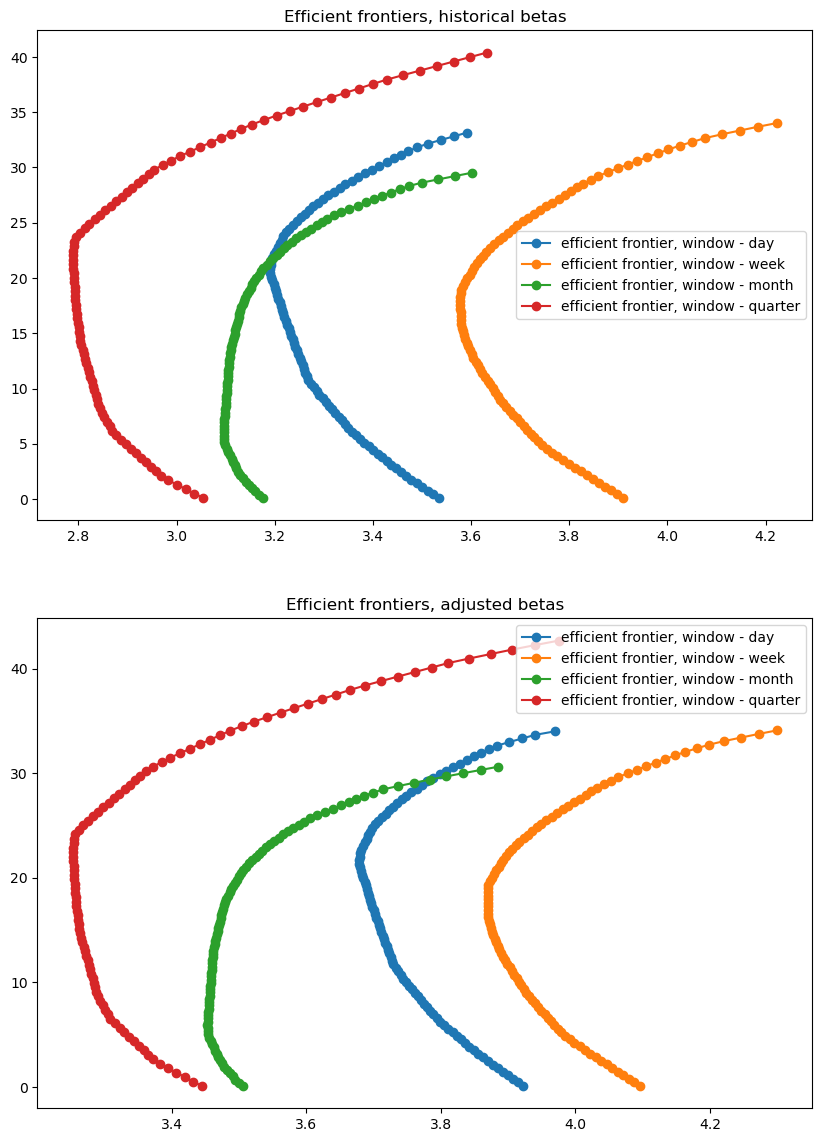

In [23]:
fig, ax = plt.subplots(2, figsize=(10, 14))

ax[0].title.set_text(f'Efficient frontiers, historical betas')
ax[1].title.set_text(f'Efficient frontiers, adjusted betas')

# историческое окно 1, окно 1
returns_windows = [1, 5, 20, 60] # день неделя месяц квартал
returns_legend = ['day', 'week', 'month', 'quarter']
flag = 0

start_date = '2019-12-31'
end_date = '2024-12-31'

# historical
for returns_window in returns_windows:

    pivot_data_1 = pivot_data[(pivot_data.index >= start_date) & (pivot_data.index <= end_date)]


    alphas, betas, expected_returns_1, variances, pivot_data_1 = find_historic_betas(pivot_data_1, returns_window=returns_window, adjusted_beta=False)

    annual_multiplier = 252/returns_window

    constarin_set = (0, 0.07)
    maxSR_std, maxSR_returns, maxSR_allocation, minVol_std, minVol_returns, minVol_allocation, efficient_list, target_returns = calculated_results(expected_returns_1 * annual_multiplier,
                                                                                                                                                   variances * annual_multiplier,
                                                                                                                                                   risk_free_rate,
                                                                                                                                                   pivot_data_1 * annual_multiplier,
                                                                                                                                                  constarin_set,
                                                                                                                                                  crazy=True)
    ax[0].plot(efficient_list,target_returns, label = f'efficient frontier, window - {returns_legend[flag]}', marker = 'o')
    flag+=1
    

# adjusted
flag = 0
for returns_window in returns_windows:

    pivot_data_1 = pivot_data[(pivot_data.index >= start_date) & (pivot_data.index <= end_date)]


    alphas, betas, expected_returns_1, variances, pivot_data_1 = find_historic_betas(pivot_data_1, returns_window=returns_window, adjusted_beta=True)

    annual_multiplier = 252/returns_window

    constarin_set = (0, 0.07)
    maxSR_std, maxSR_returns, maxSR_allocation, minVol_std, minVol_returns, minVol_allocation, efficient_list, target_returns = calculated_results(expected_returns_1 * annual_multiplier,
                                                                                                                                                   variances * annual_multiplier,
                                                                                                                                                   risk_free_rate,
                                                                                                                                                   pivot_data_1 * annual_multiplier,
                                                                                                                                                  constarin_set,
                                                                                                                                                  crazy=True)
    ax[1].plot(efficient_list,target_returns, label = f'efficient frontier, window - {returns_legend[flag]}', marker = 'o')
    flag+=1    

ax[0].legend()
ax[1].legend()

задание 19

1. Из за нестабильности результатов, полученных с помощью оценки бета-коэффициентов, пришлось использовать ограничения на вес инструментов в портефеле. Иначе самым оптимальным оказывался портфель из одного инструмента с наиболее высокой доходностью. Данная проблема возникает из-за нескольких причин: низкой ковариации между инструментами, большой разницей в оцененной ожидаемой доходности, низкой корреляцией между доходностью инструментов и индексом.

2. Вследствии наложенных ограничений, полученные портфели обладают худшей оцененной доходностью при том же риске относительно портфелей, оцененных на основе исторических доходностей. 

3. Из этого можно сделать вывод что несмотря на большие вычислительные затраты, более рационально использование оценки границы эффективных портфелей на основе исторических показателей, так как такой подход более гибок и позволяет получить более состоятельные результаты.

In [24]:
# график пункта 19 - сбор графиков